In [9]:
import numpy as np
from numpy import pi
import math

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()


ibmqfactory.load_account:WARNING:2022-12-13 06:05:30,588: Credentials are already in use. The existing account in the session will be replaced.


# Quantum Phase Estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

## Overview

The general quantum circuit for phase estimation is shown below. The top register contains $t$ 'counting' qubits, and the bottom contains qubits in the state $|\psi\rangle$:
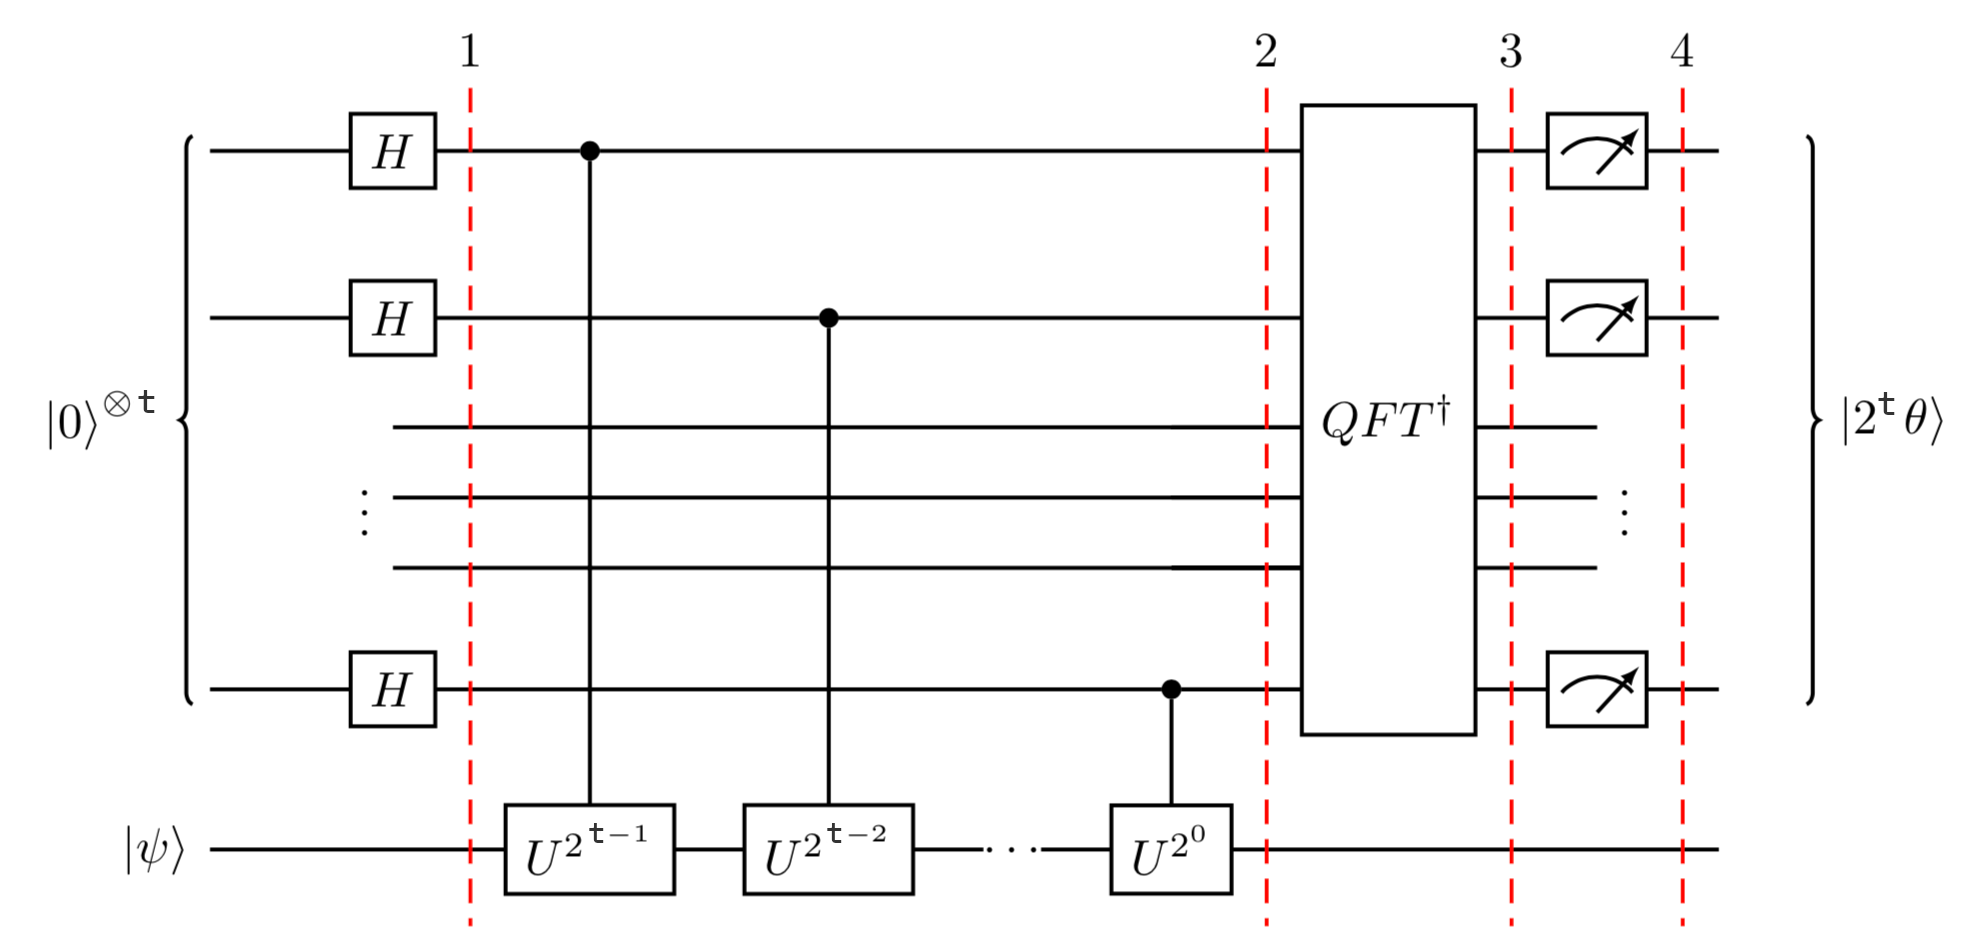


### Intuition
The quantum phase estimation algorithm uses phase kickback to write the phase of $U$ (in the Fourier basis) to the $t$ qubits in the counting register. We then use the inverse QFT to translate this from the Fourier basis into the computational basis, which we can measure.

We remember (from the QFT chapter) that in the Fourier basis the topmost qubit completes one full rotation when counting between $0$ and $2^t$. To count to a number, $x$ between $0$ and $2^t$, we rotate this qubit by $\tfrac{x}{2^t}$ around the z-axis. For the next qubit we rotate by $\tfrac{2x}{2^t}$, then $\tfrac{4x}{2^t}$ for the third qubit.

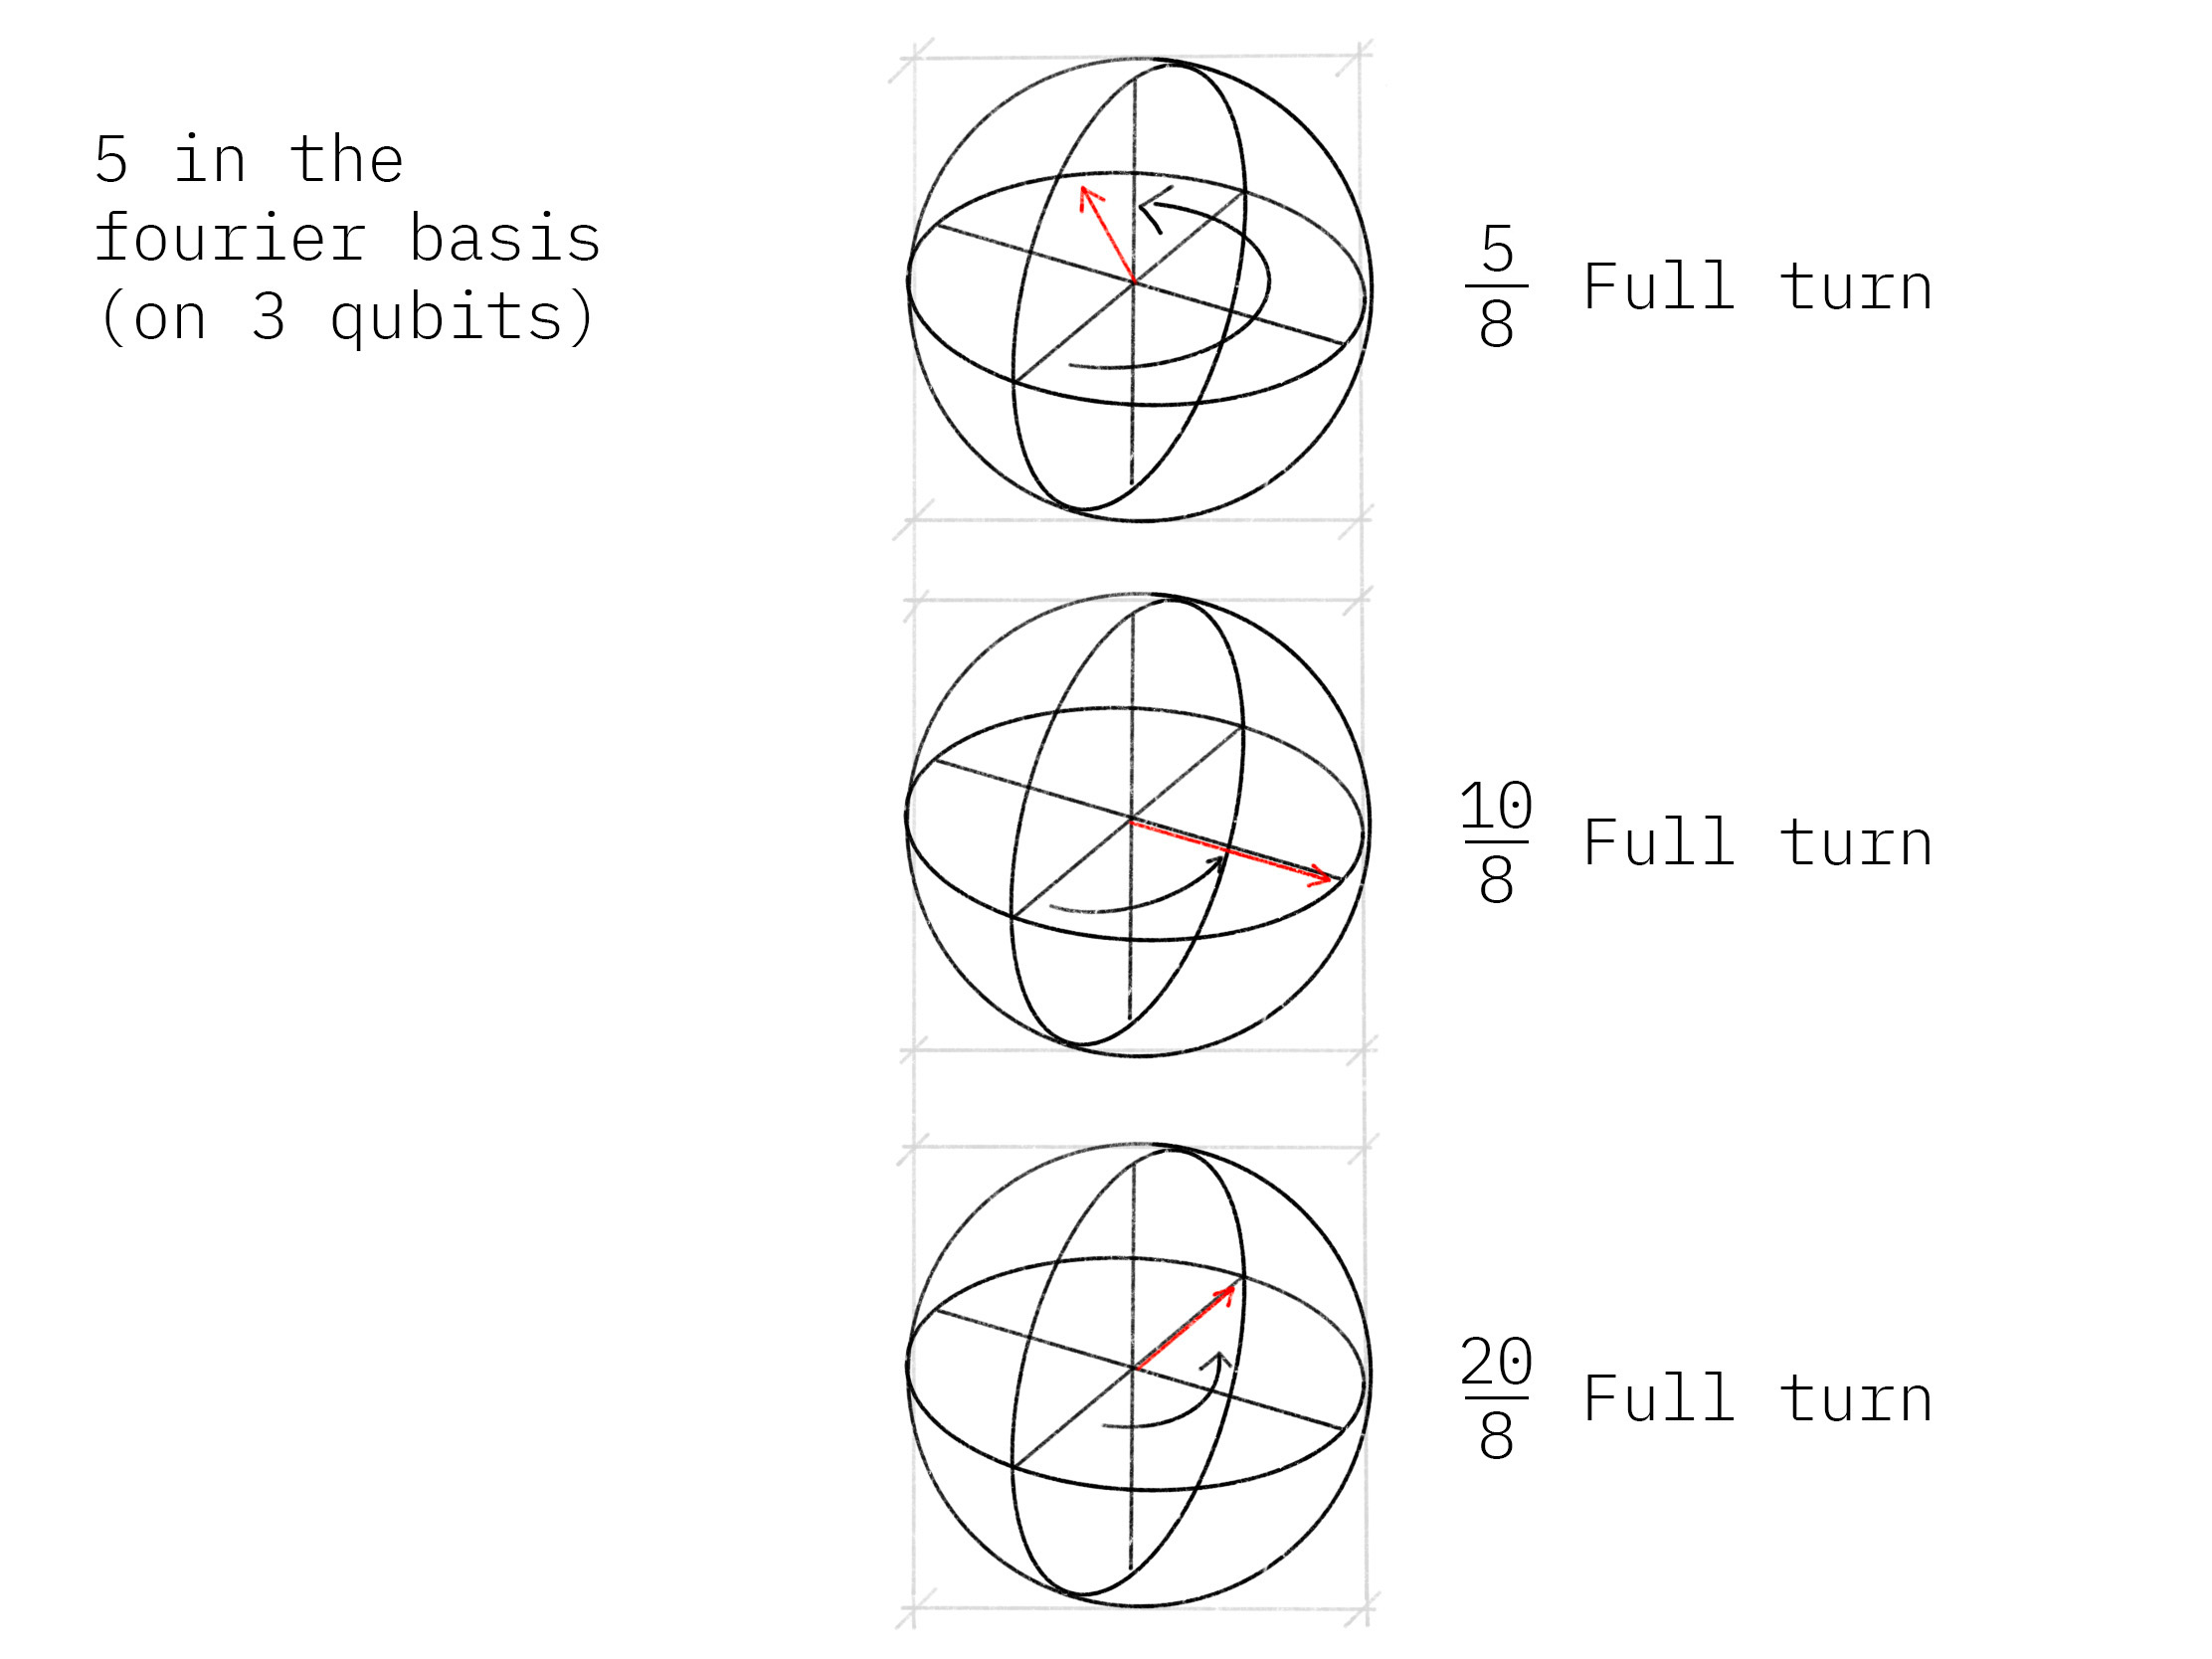

When we use a qubit to control the $U$-gate, the qubit will turn (due to kickback) proportionally to the phase $e^{2i\pi\theta}$. We can use successive $CU$-gates to repeat this rotation an appropriate number of times until we have encoded the phase theta as a number between $0$ and $2^t$ in the Fourier basis. 

Then we simply use $QFT^\dagger$ to convert this into the computational basis.



### Mathematical Foundation

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$: 



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$

 

ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register: 



$$ |\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$



iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $CU$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 



$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$



Applying all the $n$ controlled operations $CU^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
|\psi_{2}\rangle & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers. 

iv. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in the notebook on [Quantum Fourier Transform and its Qiskit Implementation](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html). Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the auxiliary register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

v. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability: 



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$.

## Example: T-gate

Let’s take a gate we know well, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$



In this example we will use three qubits and obtain an _exact_ result (not an estimation!)

### Creating the Circuit 

We set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as the eigenstate of the unitary operator ($T$). 

We initialize $\vert\psi\rangle = \vert1\rangle$ by applying an $X$ gate:

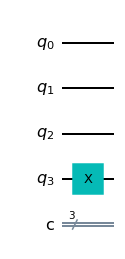

In [10]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

Next, we apply Hadamard gates to the counting qubits:

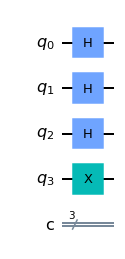

In [11]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

Next we perform the controlled unitary operations. **Remember:** Qiskit orders its qubits the opposite way round to the image above.

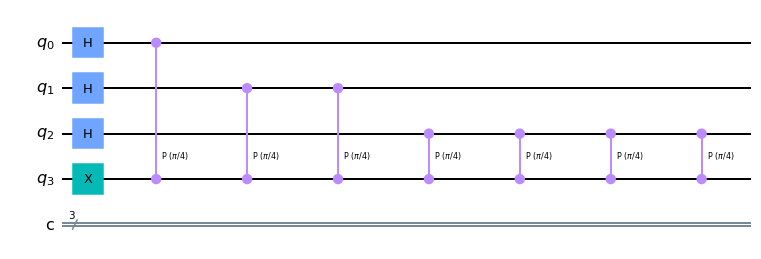

In [12]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # This is CU
    repetitions *= 2
qpe.draw()

We apply the inverse quantum Fourier transformation to convert the state of the counting register. Here we provide the code for $QFT^\dagger$:

In [13]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

We then measure the counting register:

In [14]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

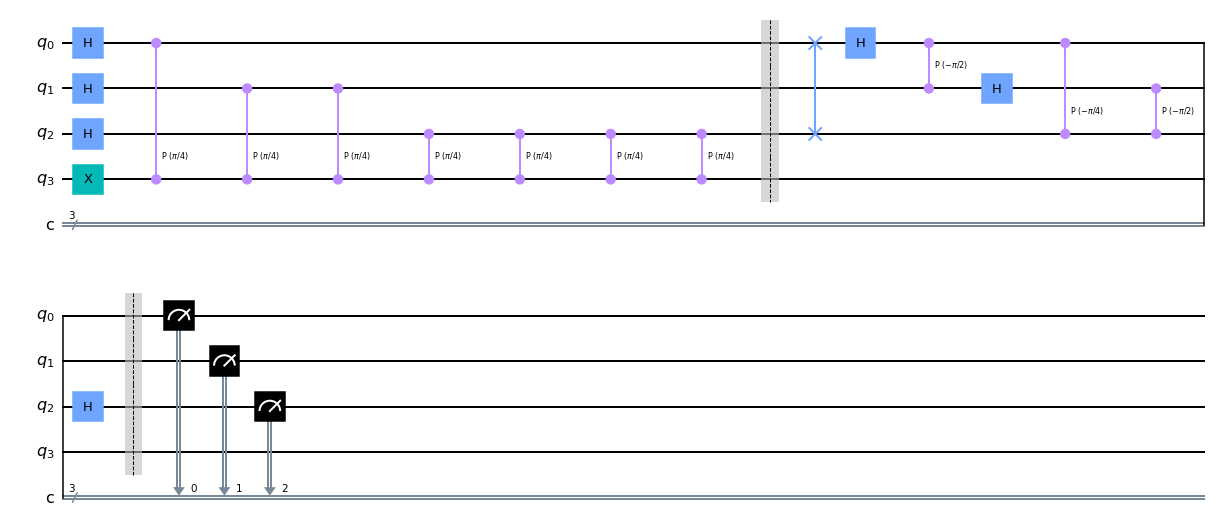

In [15]:
qpe.draw()

### Results 

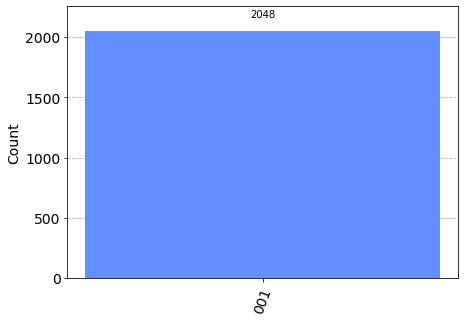

In [16]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (`001`) with certainty, which translates to the decimal: `1`. We now need to divide our result (`1`) by $2^n$ to get $\theta$:



$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$



This is exactly the result we expected!

## Example: Getting More Precision
### The Problem

Instead of a $T$-gate, let’s use a gate with $\theta = \frac{1}{3}$. We set up our circuit as with the last example:

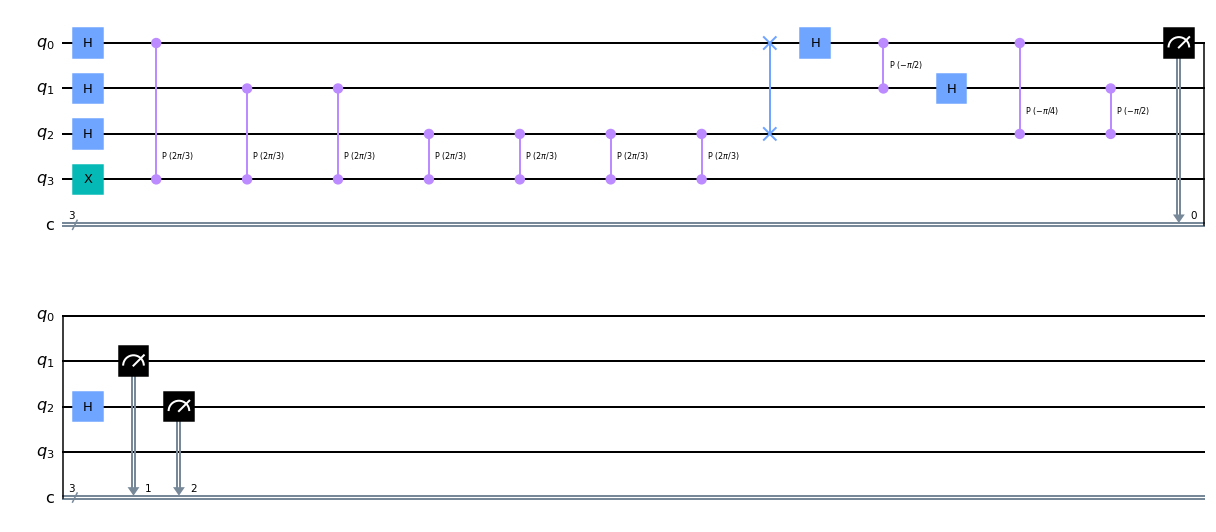

In [18]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()

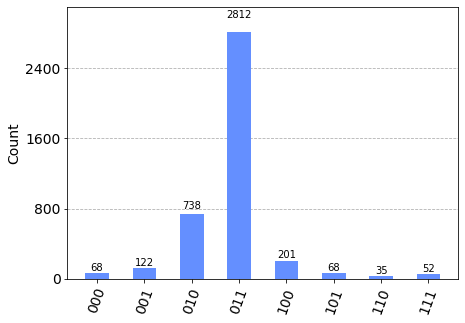

In [20]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
qobj = assemble(t_qpe2, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 0.3333\dots$, and we see our most likely results are `010(bin) = 2(dec)` and `011(bin) = 3(dec)`. These two results would tell us that $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

### The Solution 
To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

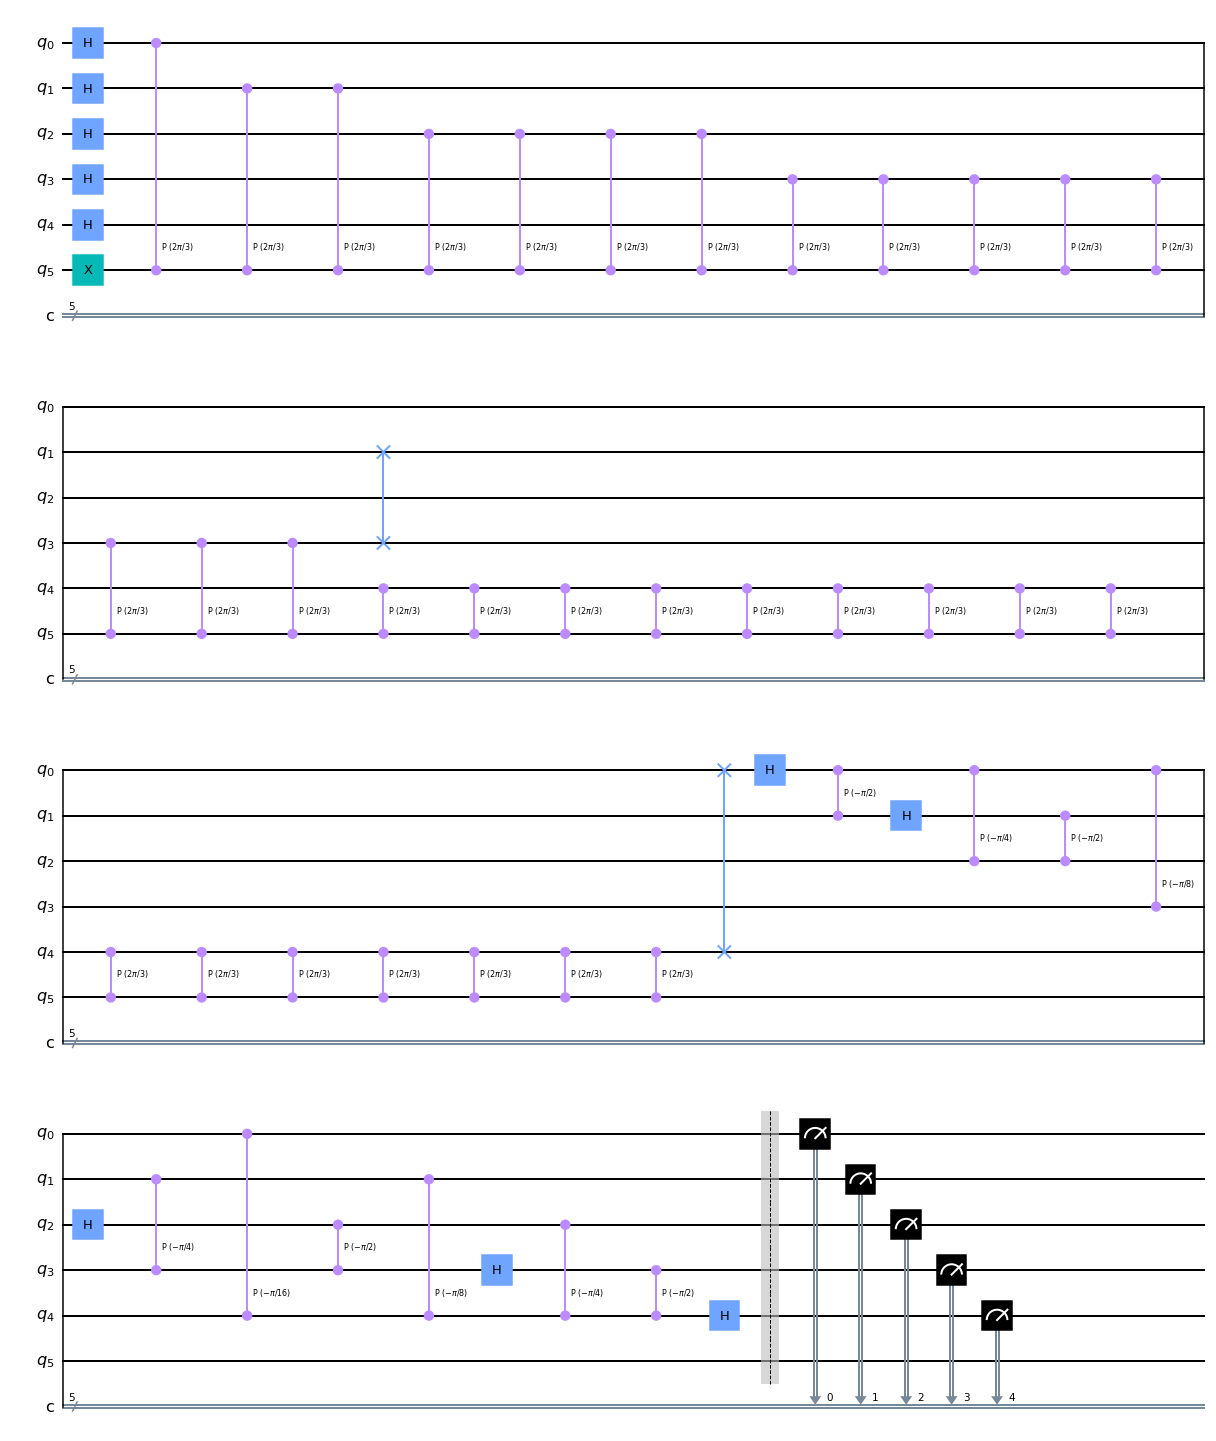

In [21]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw()

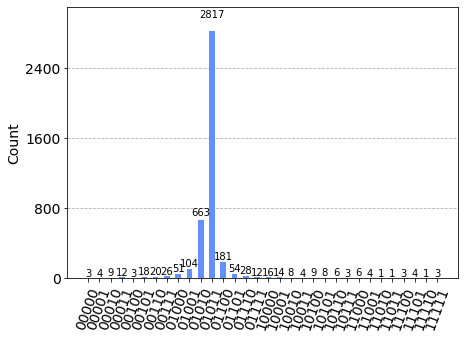

In [22]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
qobj = assemble(t_qpe3, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

The two most likely measurements are now `01011` (decimal 11) and `01010` (decimal 10). Measuring these results would tell us $\theta$ is:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{  or  }\;\; \theta = \frac{10}{2^5} = 0.313
$$

These two results differ from $\frac{1}{3}$ by 3% and 6% respectively. A much better precision!